# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize the cummulative reward by chosing the best action in all states.

As the name suggests, GAIL belongs to a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimic an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller ones to actions which substantially deviate from the expert behavior. In our case, expert trajectories were generated from real life data, namely from the interaction dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are obtained in this way, represent the expert knowledge by containing many states with corresponding actions that were produced by the expert.

As mentioned previously, learning of the agent in the RL setting is driven by the rewards it receives from the environment. The amount of the reward in the Imitation Learning setting are determined based on how closely the agent mimics the expert behavior. Special in the GAIL approach is that we receive the reward from an adversarial game: The agent is represented by a generator network which is trained based on the feedback of a discriminator network. The generator produces actions for given states which are then evaluated by the discriminator. In the meantime, the discriminator is trained by feeding it with expert and agent state-action pairs for classification. This way, the generator tries to fool the discriminator, hence he aims at acting as expert-like as possible. Meanwhile, the discriminator tries to distinguish between expert and agent trajectories. Intuitively, learning converges when the generator learned to act so similarly to the expert that the discriminator cannot tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step for minimizing the it.<br>
As already stated, training runs until both, the generator and the discriminator loss, converge to a steady state value.


The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

## Interaction Dataset
As data source, we used the interaction dataset: https://arxiv.org/abs/1910.03088. Here, we are interested in the merging scenarios: deu_merging_mt and chn_merging_zs. Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (Note that the dataset itself is NOT enclosed with bark due to license limitations).

## Expert Trajectories
As mentioned earlier, we have generated expert trajectories using the Interaction Dataset and also a trained SAC agent. The Interaction Dataset of course contains logs about many different vehicles with different wheel bases. To remedy this issue, we have used a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data. We just consider that all state trajectories were carried out by the same car and calculate the actions that a car would have needed to carry out that behavior. 

As the state variables and also the actions have diferent magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the actual environment (BARK runtime) as an input, hence the trajectories can be normalized according to the current parameters. (Current state and action spaces.)

## Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset is shown in the following. 

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
generation_params = param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]
generation_params["TrackIds"] = [63, 64, 65, 66, 67, 68]
generation_params["StartTs"] = 232000
generation_params["EndTs"] = 259000
generation_params["EgoTrackId"] = ego_agent
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"] = generation_params

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

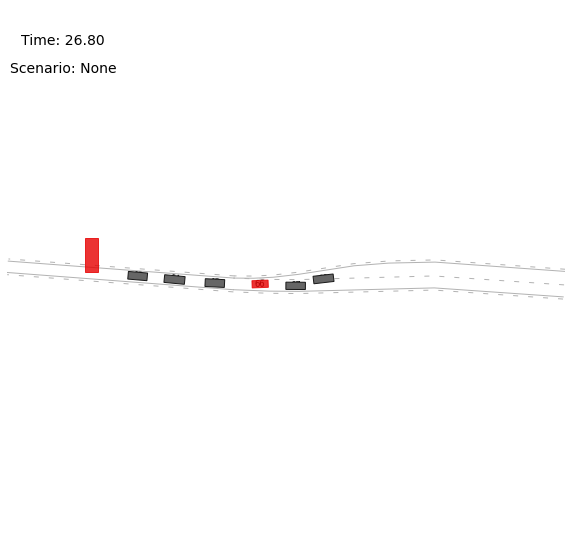

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

In [3]:
import pandas as pd
from IPython.display import display
from helpers import *

### The generated expert trajectories
The generated expert trajectories are stored in a dictionary with keys:
* `obs`: list, containing the observation vector for the timestep.
* `act`: list, containing the action that was carried out in that timestep.
* `next_obs`: list, the next observation after carrying out the action `act` in the state `obs`. 

### Format of observations

\begin{align*}
\begin{pmatrix}
x \\
y \\
\Theta \\
v
\end{pmatrix}
\text{ for the ego vehicle and the three nearest vehicles in the scene, where $x$ and $y$ are 2D coordinates, $\Theta$ is orientation and $v$ velocity.}
\end{align*}

Stored as `expert_trajectories[ego_agent]['obs']` 

In [4]:
# Small number of observations for our agent

pd.options.display.float_format = '{:,.2f}'.format
display(observations_to_dataframe(expert_trajectories[ego_agent]['obs'][:5]))

,x (0),y (0),Theta (0),v (0),x (1),y (1),Theta (1),v (1),x (2),y (2),Theta (2),v (2),x (3),y (3),Theta (3),v (3)
0,998.18,"1,006.94",3.09,2.20,995.96,"1,004.27",3.06,1.66,"1,004.67","1,006.34",3.06,1.80,"1,004.06","1,003.58",3.07,1.93
1,997.75,"1,006.96",3.09,2.19,995.63,"1,004.30",3.06,1.63,"1,004.32","1,006.37",3.06,1.78,"1,003.68","1,003.61",3.08,1.83
2,997.31,"1,006.99",3.09,2.18,995.31,"1,004.33",3.06,1.59,"1,003.97","1,006.40",3.06,1.76,"1,003.32","1,003.63",3.08,1.72
3,996.88,"1,007.01",3.09,2.17,994.99,"1,004.35",3.06,1.56,"1,003.61","1,006.42",3.06,1.74,"1,002.98","1,003.65",3.08,1.62
4,996.44,"1,007.04",3.08,2.15,994.68,"1,004.38",3.06,1.53,"1,003.27","1,006.45",3.06,1.74,"1,002.66","1,003.67",3.08,1.52


### Format of actions
\begin{align*}
\begin{pmatrix}
a \\
\delta 
\end{pmatrix}
\text{, where $a$ is acceleration and $\delta$ is steering angle.}
\end{align*}

Stored as `expert_trajectories[ego_agent]['act']` 

In [5]:
# Small number of actions from our agent

pd.options.display.float_format = '{:,.2f}'.format
display(actions_to_dataframe(expert_trajectories[ego_agent]['act'][:5]))

,Acceleration,Steering angle
0,-0.03,0.00
1,-0.04,-0.01
2,-0.07,0.00
3,-0.10,-0.01
4,-0.12,0.00


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement learning algorithms in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with actor and critic networks. Both of them have 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect, the agent is not in the traditional GAIL setup with 2 neural networks. Instead, it actually has 5 networks since the DDPG agent itself has 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of TF2RL about the environment. The observation and action normalization also takes place here.
    * source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is demonstrated. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [6]:
# Customize some parameters here!

max_steps = 100000          # Number of steps to train for.
test_interval = 100         # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [7]:
# imports
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Training graphs

The next cell deletes the previous logs and launches tensorboard. After tensorboard has launched, please go on to the next cell and start the training. The tensorboard window refreshes itself every 30 seconds, but you can also refresh it manually in the upper right corner.

You should see the graphs for:
* Common
    * Common/average_step_count: The average number of steps the agent takes in the environment per scenario
    * Common/average_test_return: The average return during the test scenarios
    * Common/fps: The steps the agent takes in the environment per second
    * Common/training_return: The per scenario return of the agent during training
* DDPG
    * DDPG/actor_loss: The loss of the actor network
    * DDPG/critic_loss: The loss of the critic network
* GAIL
    * GAIL/Accuracy: The agent/expert distinguishing accuracy of the discriminator
    * GAIL/DiscriminatorLoss: The loss of the discriminator network
    * GAIL/JSdivergence: The Jensen–Shannon divergence measureing the similarity between the expert and agent
    
Sometimes tensorboard does not refresh correctly. If you don't see all of the above graphs after 300 scenarios, please rightclick the tensorboard and click _Reload frame_.

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# launching tensorboard and deleting the previous runs logdirs:
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

# Sometimes tensorboard does not update correctly
# You should see 
# Right click the tensorboard 

zsh:kill:1: kill 119065 failed: no such process


Reusing TensorBoard on port 6006 (pid 41312), started 0:03:23 ago. (Use '!kill 41312' to kill it.)

In [ ]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                                number_of_senarios=500,
                                random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                         render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
                           normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                               params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params['ML']['ExpertTrajectories']['expert_path_dir'],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env, # the unwrapped env has to be used, since that contains the unnormalized spaces.
    subset_size=params["ML"]["ExpertTrajectories"]["subset_size"]
    ) 

# instantiate a runner that is going to train the agent
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
11:44:13.842 [INFO] (trainer.py:65) Restored None
11:44:13.887 [INFO] (irl_trainer.py:73) Total Epi:     1 Steps:       2 Episode Steps:     2 Return: -1.0000 FPS: 47.52
11:44:14.187 [INFO] (irl_trainer.py:73) Total Epi:     2 Steps:       6 Episode Steps:     4 Return: -1.0000 FPS: 763.62
11:44:14.197 [INFO] (irl_trainer.py:73) Total Epi:     3 Steps:      17 Episode Steps:    11 Return: -1.0000 FPS: 1260.64
11:44:14.204 [INFO] (irl_trainer.py:73) Total Epi:     4 Steps:      22 Episode Steps:     5 Return: -1.0000 FPS: 894.25
11:44:14.211 [INFO] (irl_trainer.py:73) Total Epi:     5 Steps:      26 Episode Steps:     4 Return: -

11:44:14.749 [INFO] (irl_trainer.py:73) Total Epi:    66 Steps:     553 Episode Steps:     4 Return: -1.0000 FPS: 812.27
11:44:14.754 [INFO] (irl_trainer.py:73) Total Epi:    67 Steps:     555 Episode Steps:     2 Return: -1.0000 FPS: 510.91
11:44:14.761 [INFO] (irl_trainer.py:73) Total Epi:    68 Steps:     558 Episode Steps:     3 Return: -1.0000 FPS: 665.90
11:44:14.766 [INFO] (irl_trainer.py:73) Total Epi:    69 Steps:     561 Episode Steps:     3 Return: -1.0000 FPS: 690.77
11:44:14.780 [INFO] (irl_trainer.py:73) Total Epi:    70 Steps:     578 Episode Steps:    17 Return: -1.0000 FPS: 1387.21
11:44:14.788 [INFO] (irl_trainer.py:73) Total Epi:    71 Steps:     584 Episode Steps:     6 Return: -1.0000 FPS: 932.52
11:44:14.794 [INFO] (irl_trainer.py:73) Total Epi:    72 Steps:     587 Episode Steps:     3 Return: -1.0000 FPS: 667.18
11:44:14.800 [INFO] (irl_trainer.py:73) Total Epi:    73 Steps:     590 Episode Steps:     3 Return: -1.0000 FPS: 671.72
11:44:14.809 [INFO] (irl_traine


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



11:44:17.791 [INFO] (irl_trainer.py:73) Total Epi:   122 Steps:    1006 Episode Steps:    42 Return: -1.0000 FPS: 16.25
11:44:17.845 [INFO] (irl_trainer.py:73) Total Epi:   123 Steps:    1008 Episode Steps:     2 Return: -1.0000 FPS: 38.20
11:44:17.893 [INFO] (irl_trainer.py:73) Total Epi:   124 Steps:    1010 Episode Steps:     2 Return: -1.0000 FPS: 42.32
11:44:17.948 [INFO] (irl_trainer.py:73) Total Epi:   125 Steps:    1012 Episode Steps:     2 Return: -1.0000 FPS: 37.67
11:44:18.003 [INFO] (irl_trainer.py:73) Total Epi:   126 Steps:    1014 Episode Steps:     2 Return: -1.0000 FPS: 37.58
11:44:18.056 [INFO] (irl_trainer.py:73) Total Epi:   127 Steps:    1016 Episode Steps:     2 Return: -1.0000 FPS: 38.88
11:44:18.109 [INFO] (irl_trainer.py:73) Total Epi:   128 Steps:    1018 Episode Steps:     2 Return: -1.0000 FPS: 38.75
11:44:18.165 [INFO] (irl_trainer.py:73) Total Epi:   129 Steps:    1020 Episode Steps:     2 Return: -1.0000 FPS: 36.82
11:44:18.216 [INFO] (irl_trainer.py:73) 

11:44:26.379 [INFO] (irl_trainer.py:73) Total Epi:   191 Steps:    1325 Episode Steps:    19 Return: -1.0000 FPS: 38.08
11:44:26.563 [INFO] (irl_trainer.py:73) Total Epi:   192 Steps:    1332 Episode Steps:     7 Return: -1.0000 FPS: 38.24
11:44:27.046 [INFO] (irl_trainer.py:73) Total Epi:   193 Steps:    1351 Episode Steps:    19 Return: -1.0000 FPS: 39.52
11:44:27.181 [INFO] (irl_trainer.py:73) Total Epi:   194 Steps:    1356 Episode Steps:     5 Return: -1.0000 FPS: 37.32
11:44:27.542 [INFO] (irl_trainer.py:73) Total Epi:   195 Steps:    1370 Episode Steps:    14 Return: -1.0000 FPS: 39.03
11:44:27.684 [INFO] (irl_trainer.py:73) Total Epi:   196 Steps:    1375 Episode Steps:     5 Return: -1.0000 FPS: 35.61
11:44:28.229 [INFO] (irl_trainer.py:73) Total Epi:   197 Steps:    1396 Episode Steps:    21 Return: -1.0000 FPS: 38.65
11:44:28.341 [INFO] (irl_trainer.py:73) Total Epi:   198 Steps:    1400 Episode Steps:     4 Return: -1.0000 FPS: 36.21
11:44:28.851 [INFO] (irl_trainer.py:73) 

11:44:53.427 [INFO] (irl_trainer.py:73) Total Epi:   259 Steps:    2337 Episode Steps:    17 Return: -1.0000 FPS: 37.69
11:44:53.823 [INFO] (irl_trainer.py:73) Total Epi:   260 Steps:    2352 Episode Steps:    15 Return: -1.0000 FPS: 38.02
11:44:54.125 [INFO] (irl_trainer.py:73) Total Epi:   261 Steps:    2364 Episode Steps:    12 Return: -1.0000 FPS: 39.92
11:44:54.381 [INFO] (irl_trainer.py:73) Total Epi:   262 Steps:    2374 Episode Steps:    10 Return: -1.0000 FPS: 39.43
11:44:54.713 [INFO] (irl_trainer.py:73) Total Epi:   263 Steps:    2387 Episode Steps:    13 Return: -1.0000 FPS: 39.27
11:44:55.051 [INFO] (irl_trainer.py:73) Total Epi:   264 Steps:    2400 Episode Steps:    13 Return: -1.0000 FPS: 38.70
11:44:55.401 [INFO] (irl_trainer.py:73) Total Epi:   265 Steps:    2412 Episode Steps:    12 Return: -1.0000 FPS: 34.59
11:44:55.829 [INFO] (irl_trainer.py:73) Total Epi:   266 Steps:    2429 Episode Steps:    17 Return: -1.0000 FPS: 39.85
11:44:56.279 [INFO] (irl_trainer.py:73) 

11:45:16.499 [INFO] (irl_trainer.py:73) Total Epi:   327 Steps:    3199 Episode Steps:    13 Return: -1.0000 FPS: 38.37
11:45:16.693 [INFO] (irl_trainer.py:73) Total Epi:   328 Steps:    3205 Episode Steps:     6 Return: -1.0000 FPS: 31.17
11:45:16.852 [INFO] (irl_trainer.py:73) Total Epi:   329 Steps:    3211 Episode Steps:     6 Return: -1.0000 FPS: 38.11
11:45:17.195 [INFO] (irl_trainer.py:73) Total Epi:   330 Steps:    3224 Episode Steps:    13 Return: -1.0000 FPS: 38.08
11:45:17.398 [INFO] (irl_trainer.py:73) Total Epi:   331 Steps:    3232 Episode Steps:     8 Return: -1.0000 FPS: 39.88
11:45:17.754 [INFO] (irl_trainer.py:73) Total Epi:   332 Steps:    3245 Episode Steps:    13 Return: -1.0000 FPS: 36.68
11:45:18.137 [INFO] (irl_trainer.py:73) Total Epi:   333 Steps:    3259 Episode Steps:    14 Return: -1.0000 FPS: 36.73
11:45:18.462 [INFO] (irl_trainer.py:73) Total Epi:   334 Steps:    3271 Episode Steps:    12 Return: -1.0000 FPS: 37.02
11:45:18.661 [INFO] (irl_trainer.py:73) 

11:45:38.084 [INFO] (irl_trainer.py:73) Total Epi:   396 Steps:    4011 Episode Steps:    14 Return: -1.0000 FPS: 36.37
11:45:38.432 [INFO] (irl_trainer.py:73) Total Epi:   397 Steps:    4025 Episode Steps:    14 Return: -1.0000 FPS: 40.35
11:45:38.565 [INFO] (irl_trainer.py:73) Total Epi:   398 Steps:    4030 Episode Steps:     5 Return: -1.0000 FPS: 38.07
11:45:38.720 [INFO] (irl_trainer.py:73) Total Epi:   399 Steps:    4036 Episode Steps:     6 Return: -1.0000 FPS: 39.09
11:45:39.053 [INFO] (irl_trainer.py:73) Total Epi:   400 Steps:    4049 Episode Steps:    13 Return: -1.0000 FPS: 39.30
11:45:39.216 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    4049 Average Reward -1.0000 / Average Step Count  16.0 over  5 episodes
11:45:39.223 [INFO] (irl_trainer.py:73) Total Epi:   401 Steps:    4050 Episode Steps:     1 Return: -1.0000 FPS:  5.94
11:45:39.680 [INFO] (irl_trainer.py:73) Total Epi:   402 Steps:    4067 Episode Steps:    17 Return:  1.0000 FPS: 37.28
11:45:39.944 [INFO] 

11:46:01.725 [INFO] (irl_trainer.py:73) Total Epi:   464 Steps:    4900 Episode Steps:     6 Return: -1.0000 FPS: 38.29
11:46:02.033 [INFO] (irl_trainer.py:73) Total Epi:   465 Steps:    4911 Episode Steps:    11 Return:  1.0000 FPS: 35.90
11:46:02.601 [INFO] (irl_trainer.py:73) Total Epi:   466 Steps:    4932 Episode Steps:    21 Return:  1.0000 FPS: 37.08
11:46:03.084 [INFO] (irl_trainer.py:73) Total Epi:   467 Steps:    4950 Episode Steps:    18 Return:  1.0000 FPS: 37.44
11:46:03.365 [INFO] (irl_trainer.py:73) Total Epi:   468 Steps:    4960 Episode Steps:    10 Return: -1.0000 FPS: 35.73
11:46:03.517 [INFO] (irl_trainer.py:73) Total Epi:   469 Steps:    4966 Episode Steps:     6 Return: -1.0000 FPS: 40.05
11:46:04.046 [INFO] (irl_trainer.py:73) Total Epi:   470 Steps:    4986 Episode Steps:    20 Return:  1.0000 FPS: 37.93
11:46:04.701 [INFO] (irl_trainer.py:73) Total Epi:   471 Steps:    5010 Episode Steps:    24 Return: -1.0000 FPS: 36.73
11:46:04.893 [INFO] (irl_trainer.py:73) 

11:46:28.363 [INFO] (irl_trainer.py:73) Total Epi:   532 Steps:    5891 Episode Steps:     8 Return: -1.0000 FPS: 39.19
11:46:28.676 [INFO] (irl_trainer.py:73) Total Epi:   533 Steps:    5902 Episode Steps:    11 Return: -1.0000 FPS: 35.32
11:46:28.787 [INFO] (irl_trainer.py:73) Total Epi:   534 Steps:    5906 Episode Steps:     4 Return: -1.0000 FPS: 36.63
11:46:28.896 [INFO] (irl_trainer.py:73) Total Epi:   535 Steps:    5910 Episode Steps:     4 Return: -1.0000 FPS: 37.30
11:46:29.374 [INFO] (irl_trainer.py:73) Total Epi:   536 Steps:    5928 Episode Steps:    18 Return:  1.0000 FPS: 37.82
11:46:29.711 [INFO] (irl_trainer.py:73) Total Epi:   537 Steps:    5941 Episode Steps:    13 Return: -1.0000 FPS: 38.72
11:46:29.849 [INFO] (irl_trainer.py:73) Total Epi:   538 Steps:    5946 Episode Steps:     5 Return: -1.0000 FPS: 36.72
11:46:30.474 [INFO] (irl_trainer.py:73) Total Epi:   539 Steps:    5970 Episode Steps:    24 Return: -1.0000 FPS: 38.48
11:46:31.201 [INFO] (irl_trainer.py:73) 

11:46:50.961 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    6741 Average Reward -0.6000 / Average Step Count  13.8 over  5 episodes
11:46:50.969 [INFO] (irl_trainer.py:73) Total Epi:   601 Steps:    6742 Episode Steps:     1 Return: -1.0000 FPS:  7.49
11:46:51.099 [INFO] (irl_trainer.py:73) Total Epi:   602 Steps:    6747 Episode Steps:     5 Return: -1.0000 FPS: 38.93
11:46:51.202 [INFO] (irl_trainer.py:73) Total Epi:   603 Steps:    6751 Episode Steps:     4 Return: -1.0000 FPS: 39.45
11:46:51.304 [INFO] (irl_trainer.py:73) Total Epi:   604 Steps:    6755 Episode Steps:     4 Return: -1.0000 FPS: 39.68
11:46:51.854 [INFO] (irl_trainer.py:73) Total Epi:   605 Steps:    6776 Episode Steps:    21 Return:  1.0000 FPS: 38.29
11:46:52.502 [INFO] (irl_trainer.py:73) Total Epi:   606 Steps:    6800 Episode Steps:    24 Return: -1.0000 FPS: 37.12
11:46:52.792 [INFO] (irl_trainer.py:73) Total Epi:   607 Steps:    6810 Episode Steps:    10 Return:  1.0000 FPS: 34.67
11:46:53.254 [INFO] 

11:47:13.813 [INFO] (irl_trainer.py:73) Total Epi:   669 Steps:    7600 Episode Steps:    17 Return:  1.0000 FPS: 38.48
11:47:13.940 [INFO] (irl_trainer.py:73) Total Epi:   670 Steps:    7604 Episode Steps:     4 Return: -1.0000 FPS: 31.93
11:47:14.086 [INFO] (irl_trainer.py:73) Total Epi:   671 Steps:    7610 Episode Steps:     6 Return: -1.0000 FPS: 41.58
11:47:14.229 [INFO] (irl_trainer.py:73) Total Epi:   672 Steps:    7615 Episode Steps:     5 Return: -1.0000 FPS: 35.13
11:47:14.669 [INFO] (irl_trainer.py:73) Total Epi:   673 Steps:    7632 Episode Steps:    17 Return:  1.0000 FPS: 38.82
11:47:15.098 [INFO] (irl_trainer.py:73) Total Epi:   674 Steps:    7647 Episode Steps:    15 Return: -1.0000 FPS: 35.14
11:47:15.236 [INFO] (irl_trainer.py:73) Total Epi:   675 Steps:    7652 Episode Steps:     5 Return: -1.0000 FPS: 36.80
11:47:15.699 [INFO] (irl_trainer.py:73) Total Epi:   676 Steps:    7669 Episode Steps:    17 Return:  1.0000 FPS: 36.83
11:47:15.860 [INFO] (irl_trainer.py:73) 

11:47:39.703 [INFO] (irl_trainer.py:73) Total Epi:   737 Steps:    8555 Episode Steps:    19 Return: -1.0000 FPS: 36.25
11:47:40.232 [INFO] (irl_trainer.py:73) Total Epi:   738 Steps:    8574 Episode Steps:    19 Return: -1.0000 FPS: 36.07
11:47:40.682 [INFO] (irl_trainer.py:73) Total Epi:   739 Steps:    8591 Episode Steps:    17 Return: -1.0000 FPS: 37.85
11:47:41.297 [INFO] (irl_trainer.py:73) Total Epi:   740 Steps:    8612 Episode Steps:    21 Return: -1.0000 FPS: 34.26
11:47:41.853 [INFO] (irl_trainer.py:73) Total Epi:   741 Steps:    8632 Episode Steps:    20 Return:  1.0000 FPS: 36.05
11:47:42.630 [INFO] (irl_trainer.py:73) Total Epi:   742 Steps:    8652 Episode Steps:    20 Return:  1.0000 FPS: 25.82
11:47:43.163 [INFO] (irl_trainer.py:73) Total Epi:   743 Steps:    8671 Episode Steps:    19 Return: -1.0000 FPS: 35.75
11:47:43.799 [INFO] (irl_trainer.py:73) Total Epi:   744 Steps:    8691 Episode Steps:    20 Return:  1.0000 FPS: 31.54
11:47:44.096 [INFO] (irl_trainer.py:73) 

11:48:10.137 [INFO] (irl_trainer.py:73) Total Epi:   805 Steps:    9626 Episode Steps:     9 Return:  1.0000 FPS: 37.51
11:48:10.355 [INFO] (irl_trainer.py:73) Total Epi:   806 Steps:    9634 Episode Steps:     8 Return:  1.0000 FPS: 37.01
11:48:10.905 [INFO] (irl_trainer.py:73) Total Epi:   807 Steps:    9654 Episode Steps:    20 Return: -1.0000 FPS: 36.45
11:48:11.546 [INFO] (irl_trainer.py:73) Total Epi:   808 Steps:    9676 Episode Steps:    22 Return:  1.0000 FPS: 34.43
11:48:12.076 [INFO] (irl_trainer.py:73) Total Epi:   809 Steps:    9694 Episode Steps:    18 Return:  1.0000 FPS: 34.06
11:48:12.584 [INFO] (irl_trainer.py:73) Total Epi:   810 Steps:    9712 Episode Steps:    18 Return:  1.0000 FPS: 35.59
11:48:13.108 [INFO] (irl_trainer.py:73) Total Epi:   811 Steps:    9731 Episode Steps:    19 Return:  1.0000 FPS: 36.35
11:48:13.732 [INFO] (irl_trainer.py:73) Total Epi:   812 Steps:    9753 Episode Steps:    22 Return: -1.0000 FPS: 35.40
11:48:14.382 [INFO] (irl_trainer.py:73) 

11:48:37.629 [INFO] (irl_trainer.py:73) Total Epi:   874 Steps:   10606 Episode Steps:     5 Return: -1.0000 FPS: 36.40
11:48:37.924 [INFO] (irl_trainer.py:73) Total Epi:   875 Steps:   10616 Episode Steps:    10 Return:  1.0000 FPS: 34.15
11:48:38.566 [INFO] (irl_trainer.py:73) Total Epi:   876 Steps:   10639 Episode Steps:    23 Return: -1.0000 FPS: 35.93
11:48:39.021 [INFO] (irl_trainer.py:73) Total Epi:   877 Steps:   10656 Episode Steps:    17 Return:  1.0000 FPS: 37.47
11:48:39.592 [INFO] (irl_trainer.py:73) Total Epi:   878 Steps:   10676 Episode Steps:    20 Return:  1.0000 FPS: 35.15
11:48:40.209 [INFO] (irl_trainer.py:73) Total Epi:   879 Steps:   10698 Episode Steps:    22 Return: -1.0000 FPS: 35.78
11:48:40.770 [INFO] (irl_trainer.py:73) Total Epi:   880 Steps:   10717 Episode Steps:    19 Return:  1.0000 FPS: 33.99
11:48:41.266 [INFO] (irl_trainer.py:73) Total Epi:   881 Steps:   10735 Episode Steps:    18 Return:  1.0000 FPS: 36.39
11:48:41.810 [INFO] (irl_trainer.py:73) 

11:49:06.941 [INFO] (irl_trainer.py:73) Total Epi:   942 Steps:   11638 Episode Steps:    21 Return:  1.0000 FPS: 34.91
11:49:07.222 [INFO] (irl_trainer.py:73) Total Epi:   943 Steps:   11648 Episode Steps:    10 Return: -1.0000 FPS: 35.82
11:49:07.513 [INFO] (irl_trainer.py:73) Total Epi:   944 Steps:   11658 Episode Steps:    10 Return:  1.0000 FPS: 34.56
11:49:08.144 [INFO] (irl_trainer.py:73) Total Epi:   945 Steps:   11681 Episode Steps:    23 Return:  1.0000 FPS: 36.56
11:49:08.663 [INFO] (irl_trainer.py:73) Total Epi:   946 Steps:   11700 Episode Steps:    19 Return:  1.0000 FPS: 36.75
11:49:08.849 [INFO] (irl_trainer.py:73) Total Epi:   947 Steps:   11706 Episode Steps:     6 Return: -1.0000 FPS: 32.59
11:49:09.697 [INFO] (irl_trainer.py:73) Total Epi:   948 Steps:   11737 Episode Steps:    31 Return:  1.0000 FPS: 36.61
11:49:10.191 [INFO] (irl_trainer.py:73) Total Epi:   949 Steps:   11755 Episode Steps:    18 Return:  1.0000 FPS: 36.57
11:49:10.361 [INFO] (irl_trainer.py:73) 

11:49:33.275 [INFO] (irl_trainer.py:73) Total Epi:  1007 Steps:   12542 Episode Steps:    19 Return:  1.0000 FPS: 35.48
11:49:33.550 [INFO] (irl_trainer.py:73) Total Epi:  1008 Steps:   12552 Episode Steps:    10 Return: -1.0000 FPS: 36.61
11:49:34.010 [INFO] (irl_trainer.py:73) Total Epi:  1009 Steps:   12568 Episode Steps:    16 Return:  1.0000 FPS: 34.88
11:49:34.255 [INFO] (irl_trainer.py:73) Total Epi:  1010 Steps:   12577 Episode Steps:     9 Return: -1.0000 FPS: 36.95
11:49:34.834 [INFO] (irl_trainer.py:73) Total Epi:  1011 Steps:   12598 Episode Steps:    21 Return:  1.0000 FPS: 36.42
11:49:35.130 [INFO] (irl_trainer.py:73) Total Epi:  1012 Steps:   12608 Episode Steps:    10 Return: -1.0000 FPS: 33.99
11:49:35.324 [INFO] (irl_trainer.py:73) Total Epi:  1013 Steps:   12615 Episode Steps:     7 Return: -1.0000 FPS: 36.29
11:49:35.553 [INFO] (irl_trainer.py:73) Total Epi:  1014 Steps:   12624 Episode Steps:     9 Return: -1.0000 FPS: 39.55
11:49:35.750 [INFO] (irl_trainer.py:73) 

11:49:57.722 [INFO] (irl_trainer.py:73) Total Epi:  1076 Steps:   13415 Episode Steps:    25 Return:  1.0000 FPS: 34.91
11:49:57.946 [INFO] (irl_trainer.py:73) Total Epi:  1077 Steps:   13423 Episode Steps:     8 Return: -1.0000 FPS: 36.14
11:49:58.167 [INFO] (irl_trainer.py:73) Total Epi:  1078 Steps:   13431 Episode Steps:     8 Return: -1.0000 FPS: 36.41
11:49:58.339 [INFO] (irl_trainer.py:73) Total Epi:  1079 Steps:   13437 Episode Steps:     6 Return: -1.0000 FPS: 35.30
11:49:58.588 [INFO] (irl_trainer.py:73) Total Epi:  1080 Steps:   13446 Episode Steps:     9 Return: -1.0000 FPS: 36.31
11:49:59.161 [INFO] (irl_trainer.py:73) Total Epi:  1081 Steps:   13467 Episode Steps:    21 Return:  1.0000 FPS: 36.79
11:49:59.642 [INFO] (irl_trainer.py:73) Total Epi:  1082 Steps:   13484 Episode Steps:    17 Return:  1.0000 FPS: 35.45
11:49:59.915 [INFO] (irl_trainer.py:73) Total Epi:  1083 Steps:   13494 Episode Steps:    10 Return: -1.0000 FPS: 36.89
11:50:00.085 [INFO] (irl_trainer.py:73) 

11:50:19.833 [INFO] (irl_trainer.py:73) Total Epi:  1144 Steps:   14200 Episode Steps:     8 Return: -1.0000 FPS: 39.00
11:50:20.373 [INFO] (irl_trainer.py:73) Total Epi:  1145 Steps:   14219 Episode Steps:    19 Return:  1.0000 FPS: 35.30
11:50:20.824 [INFO] (irl_trainer.py:73) Total Epi:  1146 Steps:   14236 Episode Steps:    17 Return:  1.0000 FPS: 37.86
11:50:21.049 [INFO] (irl_trainer.py:73) Total Epi:  1147 Steps:   14244 Episode Steps:     8 Return: -1.0000 FPS: 35.78
11:50:21.604 [INFO] (irl_trainer.py:73) Total Epi:  1148 Steps:   14264 Episode Steps:    20 Return:  1.0000 FPS: 36.17
11:50:22.095 [INFO] (irl_trainer.py:73) Total Epi:  1149 Steps:   14282 Episode Steps:    18 Return:  1.0000 FPS: 36.79
11:50:22.679 [INFO] (irl_trainer.py:73) Total Epi:  1150 Steps:   14302 Episode Steps:    20 Return:  1.0000 FPS: 34.38
11:50:23.322 [INFO] (irl_trainer.py:73) Total Epi:  1151 Steps:   14325 Episode Steps:    23 Return:  1.0000 FPS: 35.82
11:50:23.768 [INFO] (irl_trainer.py:73) 

11:50:44.810 [INFO] (irl_trainer.py:73) Total Epi:  1212 Steps:   15079 Episode Steps:     6 Return: -1.0000 FPS: 31.07
11:50:45.282 [INFO] (irl_trainer.py:73) Total Epi:  1213 Steps:   15093 Episode Steps:    14 Return:  1.0000 FPS: 29.79
11:50:45.880 [INFO] (irl_trainer.py:73) Total Epi:  1214 Steps:   15113 Episode Steps:    20 Return:  1.0000 FPS: 33.56
11:50:46.130 [INFO] (irl_trainer.py:73) Total Epi:  1215 Steps:   15122 Episode Steps:     9 Return: -1.0000 FPS: 36.26
11:50:46.365 [INFO] (irl_trainer.py:73) Total Epi:  1216 Steps:   15131 Episode Steps:     9 Return: -1.0000 FPS: 38.53
11:50:46.605 [INFO] (irl_trainer.py:73) Total Epi:  1217 Steps:   15140 Episode Steps:     9 Return: -1.0000 FPS: 37.79
11:50:46.761 [INFO] (irl_trainer.py:73) Total Epi:  1218 Steps:   15146 Episode Steps:     6 Return: -1.0000 FPS: 38.68
11:50:47.027 [INFO] (irl_trainer.py:73) Total Epi:  1219 Steps:   15156 Episode Steps:    10 Return: -1.0000 FPS: 37.80
11:50:47.222 [INFO] (irl_trainer.py:73) 

11:51:12.494 [INFO] (irl_trainer.py:73) Total Epi:  1281 Steps:   16060 Episode Steps:    19 Return:  1.0000 FPS: 36.51
11:51:13.030 [INFO] (irl_trainer.py:73) Total Epi:  1282 Steps:   16079 Episode Steps:    19 Return:  1.0000 FPS: 35.61
11:51:13.547 [INFO] (irl_trainer.py:73) Total Epi:  1283 Steps:   16099 Episode Steps:    20 Return:  1.0000 FPS: 38.78
11:51:14.026 [INFO] (irl_trainer.py:73) Total Epi:  1284 Steps:   16116 Episode Steps:    17 Return:  1.0000 FPS: 35.59
11:51:14.318 [INFO] (irl_trainer.py:73) Total Epi:  1285 Steps:   16127 Episode Steps:    11 Return: -1.0000 FPS: 37.95
11:51:14.498 [INFO] (irl_trainer.py:73) Total Epi:  1286 Steps:   16133 Episode Steps:     6 Return: -1.0000 FPS: 33.45
11:51:14.643 [INFO] (irl_trainer.py:73) Total Epi:  1287 Steps:   16138 Episode Steps:     5 Return: -1.0000 FPS: 34.99
11:51:15.197 [INFO] (irl_trainer.py:73) Total Epi:  1288 Steps:   16158 Episode Steps:    20 Return:  1.0000 FPS: 36.18
11:51:15.381 [INFO] (irl_trainer.py:73) 

11:51:37.425 [INFO] (irl_trainer.py:73) Total Epi:  1349 Steps:   16941 Episode Steps:     6 Return: -1.0000 FPS: 36.04
11:51:37.633 [INFO] (irl_trainer.py:73) Total Epi:  1350 Steps:   16948 Episode Steps:     7 Return: -1.0000 FPS: 33.82
11:51:38.198 [INFO] (irl_trainer.py:73) Total Epi:  1351 Steps:   16968 Episode Steps:    20 Return:  1.0000 FPS: 35.50
11:51:38.395 [INFO] (irl_trainer.py:73) Total Epi:  1352 Steps:   16975 Episode Steps:     7 Return: -1.0000 FPS: 36.04
11:51:38.933 [INFO] (irl_trainer.py:73) Total Epi:  1353 Steps:   16995 Episode Steps:    20 Return:  1.0000 FPS: 37.25
11:51:39.199 [INFO] (irl_trainer.py:73) Total Epi:  1354 Steps:   17004 Episode Steps:     9 Return: -1.0000 FPS: 34.01
11:51:39.750 [INFO] (irl_trainer.py:73) Total Epi:  1355 Steps:   17024 Episode Steps:    20 Return:  1.0000 FPS: 36.44
11:51:39.960 [INFO] (irl_trainer.py:73) Total Epi:  1356 Steps:   17031 Episode Steps:     7 Return: -1.0000 FPS: 33.58
11:51:40.228 [INFO] (irl_trainer.py:73) 

11:52:04.403 [INFO] (irl_trainer.py:73) Total Epi:  1417 Steps:   17895 Episode Steps:    25 Return:  1.0000 FPS: 35.77
11:52:04.919 [INFO] (irl_trainer.py:73) Total Epi:  1418 Steps:   17913 Episode Steps:    18 Return:  1.0000 FPS: 35.05
11:52:05.202 [INFO] (irl_trainer.py:73) Total Epi:  1419 Steps:   17923 Episode Steps:    10 Return: -1.0000 FPS: 35.62
11:52:05.760 [INFO] (irl_trainer.py:73) Total Epi:  1420 Steps:   17943 Episode Steps:    20 Return:  1.0000 FPS: 35.93
11:52:06.023 [INFO] (irl_trainer.py:73) Total Epi:  1421 Steps:   17953 Episode Steps:    10 Return:  1.0000 FPS: 38.27
11:52:06.292 [INFO] (irl_trainer.py:73) Total Epi:  1422 Steps:   17963 Episode Steps:    10 Return: -1.0000 FPS: 37.42
11:52:06.818 [INFO] (irl_trainer.py:73) Total Epi:  1423 Steps:   17982 Episode Steps:    19 Return:  1.0000 FPS: 36.22
11:52:07.373 [INFO] (irl_trainer.py:73) Total Epi:  1424 Steps:   18002 Episode Steps:    20 Return:  1.0000 FPS: 36.17
11:52:07.686 [INFO] (irl_trainer.py:73) 

11:52:31.593 [INFO] (irl_trainer.py:73) Total Epi:  1486 Steps:   18853 Episode Steps:    11 Return: -1.0000 FPS: 34.58
11:52:32.095 [INFO] (irl_trainer.py:73) Total Epi:  1487 Steps:   18871 Episode Steps:    18 Return:  1.0000 FPS: 36.01
11:52:32.403 [INFO] (irl_trainer.py:73) Total Epi:  1488 Steps:   18883 Episode Steps:    12 Return: -1.0000 FPS: 39.16
11:52:32.845 [INFO] (irl_trainer.py:73) Total Epi:  1489 Steps:   18899 Episode Steps:    16 Return:  1.0000 FPS: 36.34
11:52:33.152 [INFO] (irl_trainer.py:73) Total Epi:  1490 Steps:   18909 Episode Steps:    10 Return:  1.0000 FPS: 32.73
11:52:33.687 [INFO] (irl_trainer.py:73) Total Epi:  1491 Steps:   18928 Episode Steps:    19 Return:  1.0000 FPS: 35.72
11:52:33.959 [INFO] (irl_trainer.py:73) Total Epi:  1492 Steps:   18938 Episode Steps:    10 Return: -1.0000 FPS: 37.03
11:52:34.253 [INFO] (irl_trainer.py:73) Total Epi:  1493 Steps:   18949 Episode Steps:    11 Return: -1.0000 FPS: 37.59
11:52:34.512 [INFO] (irl_trainer.py:73) 

11:52:57.781 [INFO] (irl_trainer.py:73) Total Epi:  1554 Steps:   19780 Episode Steps:    12 Return: -1.0000 FPS: 36.08
11:52:58.112 [INFO] (irl_trainer.py:73) Total Epi:  1555 Steps:   19792 Episode Steps:    12 Return:  1.0000 FPS: 36.33
11:52:58.656 [INFO] (irl_trainer.py:73) Total Epi:  1556 Steps:   19812 Episode Steps:    20 Return:  1.0000 FPS: 36.90
11:52:59.120 [INFO] (irl_trainer.py:73) Total Epi:  1557 Steps:   19829 Episode Steps:    17 Return:  1.0000 FPS: 36.72
11:52:59.459 [INFO] (irl_trainer.py:73) Total Epi:  1558 Steps:   19841 Episode Steps:    12 Return: -1.0000 FPS: 35.57
11:52:59.756 [INFO] (irl_trainer.py:73) Total Epi:  1559 Steps:   19852 Episode Steps:    11 Return: -1.0000 FPS: 37.27
11:53:00.162 [INFO] (irl_trainer.py:73) Total Epi:  1560 Steps:   19867 Episode Steps:    15 Return:  1.0000 FPS: 37.10
11:53:00.381 [INFO] (irl_trainer.py:73) Total Epi:  1561 Steps:   19875 Episode Steps:     8 Return: -1.0000 FPS: 36.91
11:53:00.718 [INFO] (irl_trainer.py:73) 

11:53:24.647 [INFO] (irl_trainer.py:73) Total Epi:  1622 Steps:   20733 Episode Steps:    13 Return:  1.0000 FPS: 35.35
11:53:25.173 [INFO] (irl_trainer.py:73) Total Epi:  1623 Steps:   20752 Episode Steps:    19 Return:  1.0000 FPS: 36.27
11:53:25.702 [INFO] (irl_trainer.py:73) Total Epi:  1624 Steps:   20770 Episode Steps:    18 Return:  1.0000 FPS: 34.12
11:53:26.231 [INFO] (irl_trainer.py:73) Total Epi:  1625 Steps:   20789 Episode Steps:    19 Return:  1.0000 FPS: 35.99
11:53:26.786 [INFO] (irl_trainer.py:73) Total Epi:  1626 Steps:   20808 Episode Steps:    19 Return:  1.0000 FPS: 34.33
11:53:27.232 [INFO] (irl_trainer.py:73) Total Epi:  1627 Steps:   20824 Episode Steps:    16 Return:  1.0000 FPS: 36.01
11:53:27.592 [INFO] (irl_trainer.py:73) Total Epi:  1628 Steps:   20837 Episode Steps:    13 Return:  1.0000 FPS: 36.25
11:53:27.903 [INFO] (irl_trainer.py:73) Total Epi:  1629 Steps:   20848 Episode Steps:    11 Return:  1.0000 FPS: 35.62
11:53:28.357 [INFO] (irl_trainer.py:73) 

11:53:55.266 [INFO] (irl_trainer.py:73) Total Epi:  1691 Steps:   21813 Episode Steps:    17 Return:  1.0000 FPS: 34.80
11:53:55.670 [INFO] (irl_trainer.py:73) Total Epi:  1692 Steps:   21827 Episode Steps:    14 Return: -1.0000 FPS: 34.90
11:53:56.079 [INFO] (irl_trainer.py:73) Total Epi:  1693 Steps:   21842 Episode Steps:    15 Return:  1.0000 FPS: 36.76
11:53:56.628 [INFO] (irl_trainer.py:73) Total Epi:  1694 Steps:   21861 Episode Steps:    19 Return:  1.0000 FPS: 34.74
11:53:56.859 [INFO] (irl_trainer.py:73) Total Epi:  1695 Steps:   21870 Episode Steps:     9 Return:  1.0000 FPS: 39.27
11:53:57.281 [INFO] (irl_trainer.py:73) Total Epi:  1696 Steps:   21885 Episode Steps:    15 Return:  1.0000 FPS: 35.66
11:53:57.531 [INFO] (irl_trainer.py:73) Total Epi:  1697 Steps:   21895 Episode Steps:    10 Return:  1.0000 FPS: 40.29
11:53:57.930 [INFO] (irl_trainer.py:73) Total Epi:  1698 Steps:   21909 Episode Steps:    14 Return:  1.0000 FPS: 35.26
11:53:58.237 [INFO] (irl_trainer.py:73) 

11:54:25.401 [INFO] (irl_trainer.py:73) Total Epi:  1759 Steps:   22884 Episode Steps:    18 Return:  1.0000 FPS: 37.39
11:54:25.755 [INFO] (irl_trainer.py:73) Total Epi:  1760 Steps:   22897 Episode Steps:    13 Return: -1.0000 FPS: 36.90
11:54:25.953 [INFO] (irl_trainer.py:73) Total Epi:  1761 Steps:   22903 Episode Steps:     6 Return: -1.0000 FPS: 30.52
11:54:26.071 [INFO] (irl_trainer.py:73) Total Epi:  1762 Steps:   22907 Episode Steps:     4 Return: -1.0000 FPS: 34.54
11:54:26.626 [INFO] (irl_trainer.py:73) Total Epi:  1763 Steps:   22927 Episode Steps:    20 Return:  1.0000 FPS: 36.12
11:54:26.858 [INFO] (irl_trainer.py:73) Total Epi:  1764 Steps:   22936 Episode Steps:     9 Return: -1.0000 FPS: 39.00
11:54:27.344 [INFO] (irl_trainer.py:73) Total Epi:  1765 Steps:   22953 Episode Steps:    17 Return:  1.0000 FPS: 35.12
11:54:27.678 [INFO] (irl_trainer.py:73) Total Epi:  1766 Steps:   22965 Episode Steps:    12 Return: -1.0000 FPS: 36.13
11:54:28.129 [INFO] (irl_trainer.py:73) 

11:54:53.067 [INFO] (irl_trainer.py:73) Total Epi:  1827 Steps:   23874 Episode Steps:    13 Return: -1.0000 FPS: 35.56
11:54:53.646 [INFO] (irl_trainer.py:73) Total Epi:  1828 Steps:   23894 Episode Steps:    20 Return:  1.0000 FPS: 34.67
11:54:53.931 [INFO] (irl_trainer.py:73) Total Epi:  1829 Steps:   23904 Episode Steps:    10 Return: -1.0000 FPS: 35.33
11:54:54.469 [INFO] (irl_trainer.py:73) Total Epi:  1830 Steps:   23923 Episode Steps:    19 Return:  1.0000 FPS: 35.39
11:54:54.804 [INFO] (irl_trainer.py:73) Total Epi:  1831 Steps:   23935 Episode Steps:    12 Return: -1.0000 FPS: 36.02
11:54:55.134 [INFO] (irl_trainer.py:73) Total Epi:  1832 Steps:   23947 Episode Steps:    12 Return:  1.0000 FPS: 36.54
11:54:55.583 [INFO] (irl_trainer.py:73) Total Epi:  1833 Steps:   23963 Episode Steps:    16 Return:  1.0000 FPS: 35.79
11:54:56.091 [INFO] (irl_trainer.py:73) Total Epi:  1834 Steps:   23981 Episode Steps:    18 Return:  1.0000 FPS: 35.51
11:54:56.700 [INFO] (irl_trainer.py:73) 

### Trained agent visualization
Please set up the number of scenarios to visualize in the next cell!

In [ ]:
# number of scenarios to visualize
num_scenarios_to_visualize = 10

In [ ]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = "../../../com_github_gail_4_bark_large_data_store/pretrained_agents/gail/merging"

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")